In [1]:
import sys
sys.path.insert(0, '../..')

In [2]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm import tnrange, tqdm_notebook
from causal_meta.utils.data_utils import generate_data_categorical
from causal_meta.bivariate.categorical import StructuralModel

In [3]:
N = 10
num_runs = 1 # 100
num_epochs = 1000
batch_size = 100
num_test = 100000

In [4]:
train_losses = np.zeros((2, num_runs, num_epochs))
val_losses = np.zeros((2, num_runs, num_epochs))

for j in tnrange(num_runs):
    pi_A = np.random.dirichlet(np.ones(N))
    pi_B_A = np.random.dirichlet(np.ones(N), size=(N,))
    validation_set = torch.from_numpy(generate_data_categorical(num_test, pi_A, pi_B_A))
    
    model = StructuralModel(N)#, dtype=torch.float64)
    optimizer = torch.optim.RMSprop(model.modules_parameters(), lr=1e-2)
    for i in tnrange(num_epochs, leave=False):
        with torch.no_grad():
            val_loss_A_B = -torch.mean(model.model_A_B(validation_set))
            val_loss_B_A = -torch.mean(model.model_B_A(validation_set))
            val_losses[:, j, i] = [val_loss_A_B.item(), val_loss_B_A.item()]
        optimizer.zero_grad()
        inputs = torch.from_numpy(generate_data_categorical(batch_size, pi_A, pi_B_A))
        loss_A_B = -torch.mean(model.model_A_B(inputs))
        loss_B_A = -torch.mean(model.model_B_A(inputs))
        train_losses[:, j, i] = [loss_A_B.item(), loss_B_A.item()]
        loss = loss_A_B + loss_B_A
        loss.backward()
        optimizer.step()

<ipython-input-4-5e2429831fb9>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for j in tnrange(num_runs):


<ipython-input-4-5e2429831fb9>:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(num_epochs, leave=False):


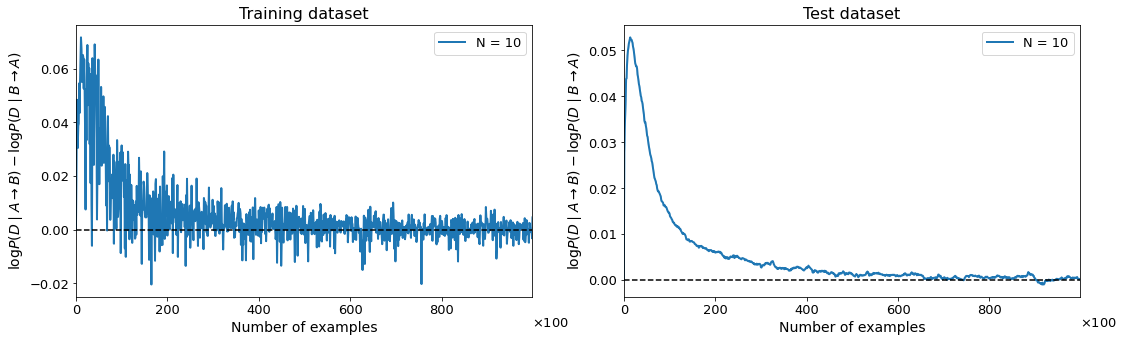

In [5]:
plt.figure(figsize=(18, 5))

ax1 = plt.subplot2grid((1, 2), (0, 0))
train_diffs = train_losses[1] - train_losses[0]
train_diffs_25, train_diffs_50, train_diffs_75 = np.percentile(train_diffs, (25, 50, 75), axis=0)
ax1.plot(train_diffs_50, 'k-', label='N = {0}'.format(N), lw=2, color='C0')
ax1.fill_between(np.arange(num_epochs), train_diffs_25, train_diffs_75, color='C0', alpha=0.2)
ax1.set_title('Training dataset', fontsize=16)

ax2 = plt.subplot2grid((1, 2), (0, 1))
val_diffs = val_losses[1] - val_losses[0]
val_diffs_25, val_diffs_50, val_diffs_75 = np.percentile(val_diffs, (25, 50, 75), axis=0)
ax2.plot(val_diffs_50, 'k-', label='N = {0}'.format(N), lw=2, color='C0')
ax2.fill_between(np.arange(num_epochs), val_diffs_25, val_diffs_75, color='C0', alpha=0.2)
ax2.set_title('Test dataset', fontsize=16)

for ax in [ax1, ax2]:
    ax.axhline(0, color='k', ls='--')
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_xlabel('Number of examples', fontsize=14)
    ax.set_ylabel(r'$\log P(D\mid A \rightarrow B) - \log P(D\mid B \rightarrow A)$', fontsize=14)
    ax.set_xlim([0, 999])
    ax.legend(prop={'size': 13})
    ax.text(1., -0.12, r'$\times 100$',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes, color='k', fontsize=13)

plt.show()